In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import  CountVectorizer

from wordcloud import WordCloud

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');



/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/tonton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tonton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tonton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def text_edit(text):
    # remove first two lines
    text = '\n'.join(text.split('\n')[2:])

    # cut longer than 2000 characters
    text = text[:2000]

    # # remove everything After Kilde:
    text = text.split('Kilde:')[0]

    # remove empty lines
    # text = '\n'.join([line for line in text.split('\n') if line != ''])

    # remove new lines
    # text = ' '.join(text.split('\n'))

    # remove double spaces
    # text = ' '.join(text.split('  '))

    # remove emojis
    # text = text.encode('ascii', 'ignore').decode('ascii')
   
    cuts = []
    # Assuming 'text' is defined and contains sentences
    sentences = text.split('.')
    num_sentences = len(sentences)
    if num_sentences > 4:

        # Create an exponential distribution for probabilities
        # The exponential distribution should favor lower indices for rand_low and higher indices for rand_high
        probabilities = np.exp(np.linspace(0, 2, num_sentences-1))
        probabilities /= probabilities.sum()  # Normalize to make it a valid probability distribution

        # Choose rand_low and rand_high using the defined probabilities
        rand_low = np.random.choice(np.arange(num_sentences-1), p=probabilities[::-1])
        rand_high = np.random.choice(np.arange(rand_low+1, num_sentences), 
                        p=probabilities[rand_low:] / probabilities[rand_low:].sum())

        # Join the selected range of sentences
        cuts.append('.'.join(sentences[rand_low:rand_high]))

    else:
        cuts.append(text)

    
    # sentences = text.split('. ')
    # num_sentences = len(sentences)
    # # if we have for example 12 setences, we want to cut it into 3 pieces
    # num_cuts = num_sentences // 4

    # for i in range(num_cuts):
    #     cuts.append('. '.join(sentences[i*4:(i+1)*4]))
        

    return cuts

def load_data():

    import os

    data = {
        'human': [],
        'bot': []
    }

    data_sources = {
        'human' : ['data/heste-nettet-nyheder/', 
                   'data/from_big_data_file/'][::-1],
        'bot' : ['data/heste-nettet-nyheder-ai/gpt-3.5-turbo/', 
                'data/heste-nettet-nyheder-ai/gpt-4-0613/', 
                 'data/from_big_data_file_ai/gpt-3.5-turbo/',
                 'data/from_big_data_file_ai/gpt-3.5-turbo-0613/'][::-1]
    }

    for source in data_sources:
        for path in data_sources[source]:
            for filename in os.listdir(path):
                with open(path + filename, 'r', encoding='utf-8') as f:
                    content = f.read()
                    cuts = text_edit(content)
                    for text in cuts:
                        data[source].append(text)

    

    # cut to same length
    min_len = min(len(data['human']), len(data['bot']))
    data['human'] = data['human'][:min_len]
    data['bot'] = data['bot'][:min_len]
    
    # shuffle data
    np.random.shuffle(data['human'])
    np.random.shuffle(data['bot'])

    my_texts = np.array(data['human'] + data['bot'])
    my_labels = np.array([0]*len(data['human']) + [1]*len(data['bot'])) 

    return list(my_texts), my_labels

# extract features from text
def num_setences(text):
    '''
    Obtains the number of sentences in a text.
    Splits on ., !, and ?
    '''
    return len(re.split(r'[.!?]+', text))

def num_words(text):
    '''
    Obtains the number of words in a text.
    Splits on whitespace.
    '''
    return len(re.split(r'\s+', text))

def num_chars(text):
    '''
    Obtains the number of characters in a text.
    '''
    return len(text)

def avg_word_length(text):
    '''
    Obtains the average word length in a text.
    '''
    words = re.split(r'\s+', text)
    return sum(len(word) for word in words) / len(words)

def num_stopwords(text):
    '''
    Obtains the number of stopwords in a text.
    '''
    words = re.split(r'\s+', text)
    stop_words = set(stopwords.words('danish'))
    return sum(word in stop_words for word in words)

def num_punctuations(text):
    '''
    Obtains the number of punctuations in a text.
    '''
    return len(re.findall(r'[^\w\s]', text))

def num_uppercase(text):
    '''
    Obtains the number of uppercase letters in a text.
    '''
    return sum(1 for c in text if c.isupper())

def num_titlecase(text):
    '''
    Obtains the number of titlecase letters in a text.
    '''
    return sum(1 for c in text if c.istitle())

def num_digits(text):
    '''
    Obtains the number of digits in a text.
    '''
    return sum(1 for c in text if c.isdigit())

def num_whitespaces(text):
    '''
    Obtains the number of whitespaces in a text.
    '''
    return sum(1 for c in text if c.isspace())

def num_words_uppercase(text):
    '''
    Obtains the number of words that are all uppercase in a text.
    '''
    words = re.split(r'\s+', text)
    return sum(word.isupper() for word in words)

def std_word_length(text):
    '''
    Obtains the standard deviation of the word length in a text.
    '''
    words = re.split(r'\s+', text)
    return np.std([len(word) for word in words])

def std_sentence_length(text):
    '''
    Obtains the standard deviation of the sentence length in a text.
    '''
    sentences = re.split(r'[.!?]+', text)
    return np.std([len(sentence) for sentence in sentences])

def std_words_per_sentence(text):
    '''
    Obtains the standard deviation of the words per sentence in a text.
    '''
    sentences = re.split(r'[.!?]+', text)
    return np.std([len(re.split(r'\s+', sentence)) for sentence in sentences])

def num_abbreviations(text):
    '''
    Obtains the number of abbreviations in a text.
    '''
    return len(re.findall(r'\b[A-Za-z]{2,}\.(?![a-z])', text))

def double_quest_excl_count(text):
    '''
    Obtains the number of double question marks and exclamation marks in a text.
    '''
    return text.count('??') + text.count('!!') + text.count('?!') + text.count('!?')

def num_excl(text):
    '''
    Obtains the number of exclamation marks in a text.
    '''
    return text.count('!')

def num_dash_quest_semicolon(text):
    '''
    Obtains the number of dashes, question marks, and semicolons in a text.
    '''
    return text.count('-') + text.count('?') + text.count(';')

def num_capital_letters(text):
    '''
    Obtains the number of capital letters in a text.
    '''
    return sum(1 for c in text if c.isupper())

def avg_capital_letters_per_sentence(text):
    '''
    Obtains the average number of capital letters per sentence in a text.
    '''
    sentences = re.split(r'[.!?]+', text)
    return np.mean([sum(1 for c in sentence if c.isupper()) for sentence in sentences])

def num_double_spaces(text):
    '''
    Obtains the number of double spaces in a text.
    '''
    return text.count('  ')

def word_lookup(text, word_lists):
    '''
    Obtains the number of occurrences of words in a text.
    '''
    words = re.split(r'\s+', text)
    return sum([sum(word in word_list for word in words) for word_list in word_lists])

# from chat gpt
def vocabulary_diversity(text):
    words = re.split(r'\s+', text)
    unique_words = set(words)
    return len(unique_words) / len(words) if words else 0

import textstat

def readability_score0(text):
    'flesch_reading_ease'
    return textstat.flesch_reading_ease(text)

def readability_score1(text):
    #'gunning_fog'
    return textstat.gunning_fog(text)

from collections import Counter
import nltk
nltk.download('punkt')

def ngram_frequency(text, n=2):
    words = nltk.word_tokenize(text)
    ngrams = nltk.ngrams(words, n)
    return Counter(ngrams)

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def syntactic_complexity(text):
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    noun_phrases = nltk.ne_chunk(tagged, binary=True)
    avg_length = np.mean([len(np) for np in noun_phrases if isinstance(np, nltk.tree.Tree)])
    return avg_length

def idiomatic_expressions_count(text, idioms):
    return sum(text.count(idiom) for idiom in idioms)

def repetition_patterns(text):
    words = text.split()
    return len(words) - len(set(words))

from textblob import TextBlob

def sentiment_consistency(text):
    blob = TextBlob(text)
    sentiments = [sentence.sentiment.polarity for sentence in blob.sentences]
    return np.std(sentiments)

def lexical_density(text):
    content_words = set(["NN", "VB", "JJ", "RB"]) # Nouns, Verbs, Adjectives, Adverbs
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    content_count = sum(1 for word, tag in tagged if tag in content_words)
    return content_count / len(words) if words else 0

def pronoun_usage(text):
    pronouns = set(["PRP", "PRP$", "WP", "WP$"]) # Personal, possessive, wh-pronouns
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    return sum(1 for _, tag in tagged if tag in pronouns)

def quotation_mark_usage(text):
    return text.count('"') + text.count("'")

def passive_voice_usage(text):
    passive_count = 0
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    for i in range(len(tagged) - 1):
        if tagged[i][1] == 'VBN' and tagged[i+1][1] in ['VBZ', 'VBP', 'VB', 'VBD', 'VBG']:
            passive_count += 1
    return passive_count


[nltk_data] Downloading package punkt to /Users/tonton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tonton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/tonton/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/tonton/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
text, labels = load_data()
data = pd.DataFrame({'text': text, 'label': labels})
# random shuffle
data = data.sample(frac=1).reset_index(drop=True)

# select only 1000 samples\
data = data[:500]
word_lists = {
    'plural_pronouns': [' vi ', ' os ', ' vores '],
    'human_fillers': [' jo ', ' jo,' ' jo!', ' lige ', ' sådan noget',  ' bestemt ',  ' bestemt!',  ' bestemt,',  ' bestemt.', ' gerne ', ' gerne!', ' gerne,', ' gerne.', ' rigtig god'],
    'ai_fillers': [' samt ', ' dette ', ' mens ', ' dog '],
    'ai_fillers2': [' en vis ', ' sammenfattende '],
    'woke_list': [' tilbøjelig ', ' tilbøjelige ', ' parter ', ' grupper ', ' organisationer ', ' organisationer.', ' føle sig ', ' føler sig '],
    'fake_news_list': [' subjektiv ', ' kilder ', ' kilder.', ' studier ', ' forklaringer ',
    ' manipulation ', ' disinformation ', ' disinformation.', ' misinformation ', ' misinformation.' ' da det ',],
    'ai_words1': [' vigtigt, at', ' vigtigt at '],
    'ai_words2': [' svært at '],
    'ai_words3': ['Jeg er en AI', 'personlige meninger eller meninger']
}

def extract_features(data, word_lists):
    data['num_sentences'] = data['text'].apply(num_setences)
    data['num_words'] = data['text'].apply(num_words)
    data['num_chars'] = data['text'].apply(num_chars)
    data['avg_words_per_sentence'] = data['num_words'] / data['num_sentences']
    data['avg_word_length'] = data['text'].apply(avg_word_length)
    data['num_stopwords'] = data['text'].apply(num_stopwords)
    data['num_punctuations'] = data['text'].apply(num_punctuations)
    data['num_uppercase'] = data['text'].apply(num_uppercase)
    data['num_titlecase'] = data['text'].apply(num_titlecase)
    data['num_digits'] = data['text'].apply(num_digits)
    data['num_whitespaces'] = data['text'].apply(num_whitespaces)
    data['num_words_uppercase'] = data['text'].apply(num_words_uppercase)
    data['std_word_length'] = data['text'].apply(std_word_length)
    data['std_sentence_length'] = data['text'].apply(std_sentence_length)
    data['std_words_per_sentence'] = data['text'].apply(std_words_per_sentence)
    data['num_abbreviations'] = data['text'].apply(num_abbreviations)
    data['double_quest_excl_count'] = data['text'].apply(double_quest_excl_count)
    data['num_excl'] = data['text'].apply(num_excl)
    data['num_dash_quest_semicolon'] = data['text'].apply(num_dash_quest_semicolon)
    data['num_capital_letters'] = data['text'].apply(num_capital_letters)
    data['avg_capital_letters_per_sentence'] = data['text'].apply(avg_capital_letters_per_sentence)
    data['num_double_spaces'] = data['text'].apply(num_double_spaces)

    # from chat gpt
    data['vocabulary_diversity'] = data['text'].apply(vocabulary_diversity)
    data['readability_score0'] = data['text'].apply(readability_score0)
    data['readability_score1'] = data['text'].apply(readability_score1)
    # data['ngram_frequency'] = data['text'].apply(ngram_frequency)
    data['syntactic_complexity'] = data['text'].apply(syntactic_complexity)
    data['idiomatic_expressions_count'] = data['text'].apply(idiomatic_expressions_count, 
                                                             idioms=['i hvert fald', 'i hvert fald?', 'i hvert fald!',
                                                                     'at slå to fluer med et smæk', 'at sluge en kamel',
                                                                     'klap lige hesten', 'klap hesten', 'på spanden',
                                                                        'at gå i hundene', 'i hegnet'])
    data['repetition_patterns'] = data['text'].apply(repetition_patterns)
    data['sentiment_consistency'] = data['text'].apply(sentiment_consistency)
    data['lexical_density'] = data['text'].apply(lexical_density)
    data['pronoun_usage'] = data['text'].apply(pronoun_usage)
    data['quotation_mark_usage'] = data['text'].apply(quotation_mark_usage)
    data['passive_voice_usage'] = data['text'].apply(passive_voice_usage)

    
    for word_list in word_lists:
        data[word_list] = data['text'].apply(lambda text: word_lookup(text, word_lists[word_list]))

    # if num sentences is 0, set to 1
    data['num_sentences'] = data['num_sentences'].apply(lambda x: 1 if x == 0 else x)

    # if num word or num char is 0 drop row
    data = data[data['num_words'] != 0]
    data = data[data['num_chars'] != 0]

    # drop cols that have no variance
    for col in data.columns[4:]:
        if len(data[col].unique()) == 1:
            print(col, 'dropped due to no variance')
            del data[col]

    # drop cols with low variance
    eps = 0.001
    for col in data.columns[4:]:
        if data[col].std()/data[col].mean() < eps:
            print(col, 'dropped due to low variance')
            del data[col]


    # for each feature get per sentence and per word and per character
    for feature in data.columns[4:]:
        # print(feature)
        data[feature + '_per_sentence'] = data[feature].values / data['num_sentences'].values
        data[feature + '_per_word'] = data[feature].values / data['num_words'].values
        # data[feature + '_per_char'] = data[feature].values / data['num_chars'].values
        del data[feature]

    return data

data = extract_features(data, word_lists)
print('data shape:', data.shape)
data.head(2)

/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


dropping double_quest_excl_count
dropping idiomatic_expressions_count
data shape: (498, 80)


,text,label,num_sentences,num_words,num_chars_per_sentence,num_chars_per_word,avg_words_per_sentence_per_sentence,avg_words_per_sentence_per_word,avg_word_length_per_sentence,avg_word_length_per_word,...,woke_list_per_sentence,woke_list_per_word,fake_news_list_per_sentence,fake_news_list_per_word,ai_words1_per_sentence,ai_words1_per_word,ai_words2_per_sentence,ai_words2_per_word,ai_words3_per_sentence,ai_words3_per_word
0,I weekenden havde jeg fornøjelsen af at delta...,1,13,278,127.923077,5.982014,1.64497,0.076923,0.382402,0.017882,...,8.538462,0.399281,16.307692,0.762590,4.923077,0.230216,1.461538,0.068345,2.000000,0.093525
1,\n\nSerummet er velegnet til alle aldre og til...,1,11,186,103.636364,6.129032,1.53719,0.090909,0.464809,0.027489,...,7.272727,0.430108,9.909091,0.586022,1.818182,0.107527,0.636364,0.037634,3.454545,0.204301


In [421]:
# shuffle the dataframe
df = data.sample(frac=1, random_state=42).reset_index(drop=True)
features = df.drop(['label', 'text', 
                    #'sentence_count'
                    ], axis=1)
features
labels = df['label']

# apply standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)


In [422]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Assuming scaled_features and labels are defined
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [6, 7, 8],  # Maximum depth of each tree, greater depth = more splits
    'learning_rate': [0.01],  # Learning rate (eta), shrinks the contribution of each tree by `learning_rate`
    'n_estimators': [3000, 5000, 7000],  # Number of trees (estimators) in the model
    'subsample': [0.5, .6, .7],  # Subsample ratio of the training instances, prevents overfitting of a tree by only using a random subset of observations per tree
    'colsample_bytree': [0.3, 0.5, .6], # Subsample ratio of features when constructing each tree, prevents overfitting by only using a random subset of features per tree
    'gamma': [0.01, 0.1, 1],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create a XGBClassifier instance
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=20, scoring='accuracy', cv=2, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

# Predict on test data
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

# Optional: Convert results to DataFrame
results_df = pd.DataFrame(random_search.cv_results_)



Fitting 2 folds for each of 20 candidates, totalling 40 fits


Best parameters: {'subsample': 0.7, 'n_estimators': 3000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best score: 0.9466560813163634
Accuracy on test data: 93.39%


In [423]:
# apply best parameters to model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=42, **random_search.best_params_)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## predictions on validation set

In [424]:
df_val = pd.read_csv('data/val.csv', index_col=0)
df_val.rename(columns={'0': 'text'}, inplace=True)
df_val['label'] = 0
df_val = extract_features(df_val, word_lists)
df_val.head(3)

/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,text,label,num_sentences,num_words,num_chars_per_sentence,num_chars_per_word,avg_words_per_sentence_per_sentence,avg_words_per_sentence_per_word,avg_word_length_per_sentence,avg_word_length_per_word,...,woke_list_per_sentence,woke_list_per_word,fake_news_list_per_sentence,fake_news_list_per_word,ai_words1_per_sentence,ai_words1_per_word,ai_words2_per_sentence,ai_words2_per_word,ai_words3_per_sentence,ai_words3_per_word
0,"I min optik er god forskning det samme som ""st...",0,5,67,76.200000,5.686567,2.680000,0.200000,0.940299,0.070172,...,8.800000,0.656716,10.0,0.746269,1.6,0.119403,0.800000,0.059701,3.400000,0.253731
1,"Jeg synes, der er rigtig gode erstatninger på ...",0,3,44,84.333333,5.750000,4.888889,0.333333,1.590909,0.108471,...,8.666667,0.590909,12.0,0.818182,2.0,0.136364,0.333333,0.022727,2.666667,0.181818
2,"Selvom der er tale om en sag, der har været i ...",0,5,94,100.200000,5.329787,3.760000,0.200000,0.863830,0.045948,...,10.800000,0.574468,15.6,0.829787,2.4,0.127660,0.600000,0.031915,3.600000,0.191489


In [430]:
# predict on validation set
features_val = df_val.drop(['text', 'label'
                            ], axis=1)

scaler = StandardScaler().fit(features_val)
scaled_features_val = scaler.transform(features_val)
y_pred_val = model.predict(scaled_features_val)

sum(y_pred_val), len(y_pred_val)

(360, 1133)

In [431]:
np.savez('xgboost_pred.npz', pred=y_pred_val)

## compare val set and train set

In [362]:
# import tsne
from sklearn.manifold import TSNE

# create tsne object
tsne = TSNE(n_components=2, random_state=42).fit(features)

# transform features and features_val
features_tsne = tsne.fit_transform(scaled_features)
features_val_tsne = tsne.fit_transform(scaled_features_val)



KeyboardInterrupt: 

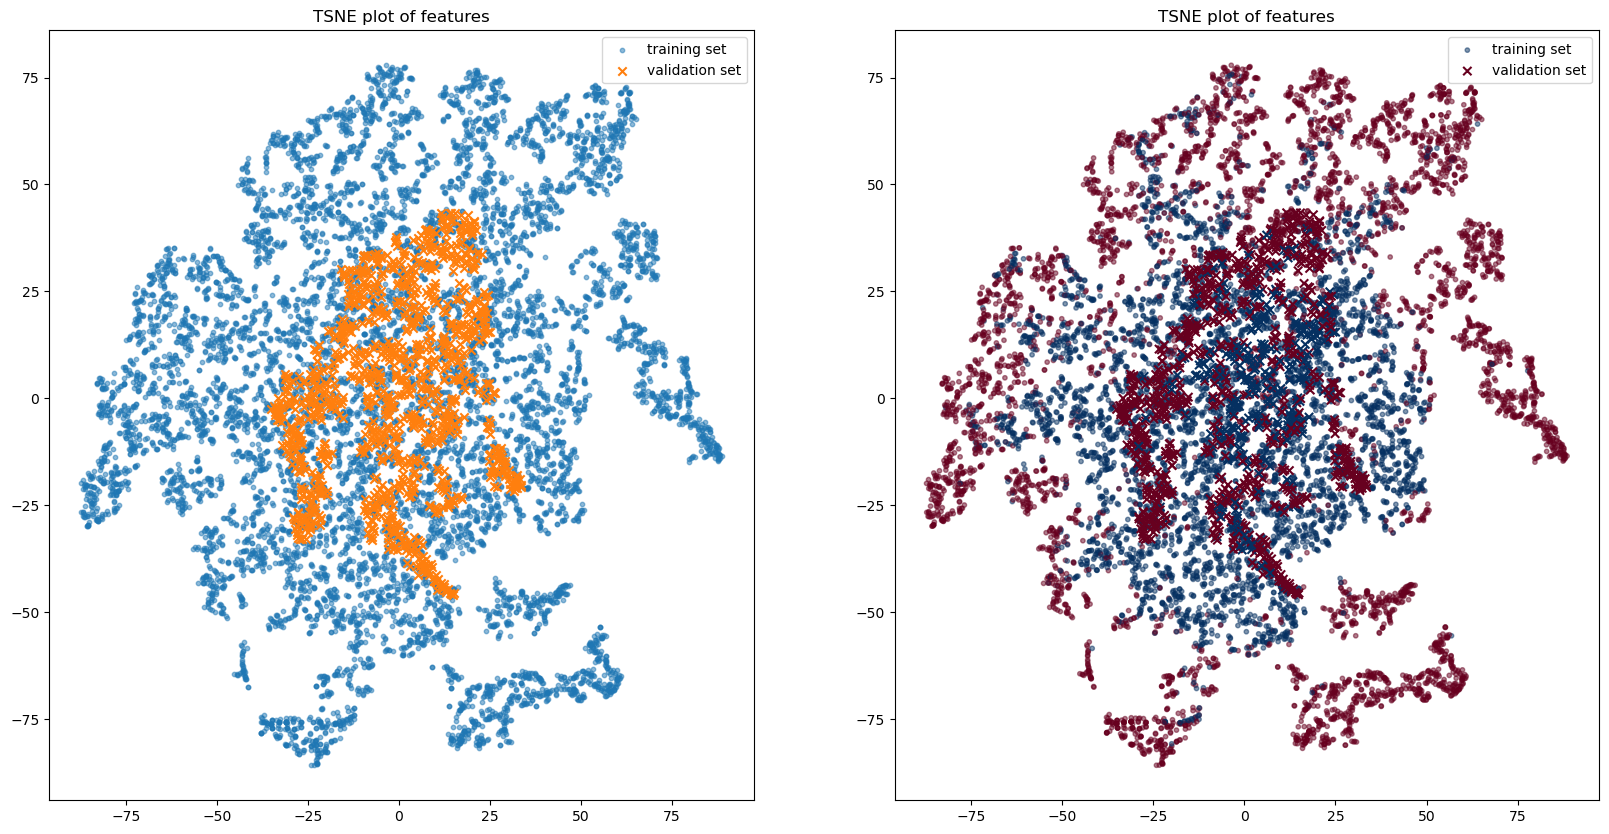

In [ ]:
select_box = np.array([
    [-37,20],
    [-50,20]
])

# plot
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(features_tsne[:, 0], features_tsne[:, 1], 
            # c=labels, 
            # cmap='Grays', 
            s=10, alpha=0.5, label='training set')
ax[0].scatter(features_val_tsne[:, 0], features_val_tsne[:, 1], 
            # c=y_pred_val, cmap='RdBu', 
            marker='x', alpha=1, label='validation set')
ax[0].set_title('TSNE plot of features')

ax[0].legend()


ax[1].scatter(features_tsne[:, 0], features_tsne[:, 1], 
            c=labels, 
            cmap='RdBu', 
            s=10, alpha=0.5, label='training set')
ax[1].scatter(features_val_tsne[:, 0], features_val_tsne[:, 1], 
            c=y_pred_val, cmap='RdBu', 
            marker='x', alpha=1, label='validation set')
ax[1].set_title('TSNE plot of features')

ax[1].legend()

# plot select box
# plt.fill_betweenx(select_box[:, 0], select_box[:, 1], color='red', alpha=0.1)
# background black

plt.show()

In [ ]:
# print sentences in select box
for i, (x, y) in enumerate(features_val_tsne):
    if select_box[0, 0] < y < select_box[0, 1] and select_box[1, 0] < x < select_box[1, 1]:
        print(f"{i}: {df_val['text'][i]}")

0: I min optik er god forskning det samme som "struktureret kreativitet". Så intuition er bestemt en god ting at have med sig - udover at man selvfølgelig skal kunne nogle forskningsteknikker. Men forskningsteknikkerne kan man lære, det er tilgengæld ikke som nemt at lære intuition. Så hvis du er en person, der er god til intuition, så er du allerede godt på vej til at blive "god".
2: Selvom der er tale om en sag, der har været i retssystemet i flere år, og som har haft en lang og omfattende behandling, så er dommen ikke blevet ud til læsning for almindeligt dødelige.

Retten har ikke truffet denne dom endnu, og det er ikke almindeligt, at domme bliver ud til læsning før de er truffet. Det er normalt, at domme først bliver ud til læsning efter at have været truffet, så de kan læses af offentligheden.

Men hvis vi ser på, hvor dommen denne gang er, så er den endnu ikke truffet.
3: Vi er ikke i en storkonflikt lige nu, men det er vigtigt at være opmærksom på, at det kan ske. Risikoen for

## Compare distribuion of features in train and test set

In [432]:
len(df.columns[2:])

82

In [433]:
fig, axes = plt.subplots(len(df.columns[2:])//4+1,4,figsize=(20,90))

for col, ax in zip(df.columns[2:], axes.flatten()):

    data_train = df[col]
    data_train_0 =  df[df['label'] == 0][col]
    data_train_1 =  df[df['label'] == 1][col]

    data_val_0 =  df_val[col]
    # data_val_1 =  df_val[df_val['label'] == 1][col]

    # define shared bins
    bins = np.linspace(min(data_train_0.min(), data_val_0.min()), max(data_train_0.max(), data_val_0.max()), 100)
    
    # plot histograms
    # ax.hist(data_train_0, bins=bins, alpha=0.5, label='train_0')
    # ax.hist(data_train_1, bins=bins, alpha=0.5, label='train_1')
    # normalized
    ax.hist(data_train, bins=bins, alpha=0.5, label='train', density=True)
    ax.hist(data_val_0, bins=bins, alpha=0.5, label='val', density=True)
    ax.set_title(col)
    ax.legend()
    ax.set_yscale('log')

plt.tight_layout()


KeyboardInterrupt: 

In [ ]:
path = '../img.npz'

import numpy as np
np.load(path, allow_pickle=True)['img'].shape


(676, 400, 3)